In [41]:
from src.libs.lib import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


df_todos_retroativos = pd.read_csv("src/data/df_todos_retroativos.csv")
df_todos_retroativos = df_todos_retroativos.loc[:, ~df_todos_retroativos.columns.str.contains('^Unnamed')] 
df_todos_retroativos['periodo'] = pd.to_datetime(df_todos_retroativos['periodo'])

df_original = pd.read_csv("src/data/df_original.csv")
df_original = df_original.loc[:, ~df_original.columns.str.contains('^Unnamed')] 
df_original['periodo'] = pd.to_datetime(df_original['periodo'])

df_comparativo = pd.read_csv("src/data/df_comparativo.csv")
df_comparativo = df_comparativo.loc[:, ~df_comparativo.columns.str.contains('^Unnamed')] 
df_comparativo['ano_mes'] = pd.to_datetime(df_comparativo['ano_mes'])

df_transportadoras = pd.read_csv("src/data/df_transportadoras.csv")
df_transportadoras = df_transportadoras.loc[:, ~df_transportadoras.columns.str.contains('^Unnamed')] 

#2.6s

# empresas com mais dias removidos

In [42]:
df_transportadoras

,company_id,company_name,freight_id,dias_reducao,houve_reducao
0,3130,OPR Logistica Pontual,140386,NaN,nao
1,1022,LOG20 - Londrina,139335,NaN,nao
2,215,IC TRANSPORTES TANQUE,139401,4.0,sim
3,3645,Madri Express Log,139305,NaN,nao
4,2432,Kona Transportes - Itapecerica,139304,NaN,nao
...,...,...,...,...,...
11717,3412,EVM EVOLUTION MOBILITY,158756,NaN,nao
11718,3335,Fit Log,159118,NaN,nao
11719,1047,Casa Assistencial Maria Helena Paulina,158715,NaN,nao
11720,704,ORIENTE LOGISTICA,159132,NaN,nao


In [43]:
# Criar colunas auxiliares para contagem condicional
df_transportadoras["com_reducao"] = df_transportadoras["houve_reducao"] == "sim"
df_transportadoras["sem_reducao"] = df_transportadoras["houve_reducao"] != "sim"

# Agrupar e calcular os dados desejados
resumo_final = (
    df_transportadoras.groupby(["company_id", "company_name"])
    .agg(
        total_contratos=("freight_id", "count"),
        com_reducao=("com_reducao", "sum"),
        sem_reducao=("sem_reducao", "sum"),
        total_dias_reducao=("dias_reducao", "sum")
    )
    .reset_index()
    .sort_values("com_reducao", ascending=False)
)
resumo_final["porcentagem_reducao"] = (
    resumo_final["com_reducao"] / resumo_final["total_contratos"]
).round(3) * 100  # porcentagem com 1 casa decimal

resumo_filtrado = resumo_final[resumo_final["total_contratos"] >= 10].copy()
resumo_final.head(20)


,company_id,company_name,total_contratos,com_reducao,sem_reducao,total_dias_reducao,porcentagem_reducao
275,2103,FSJ - JANAINA,194,46,148,214.0,23.7
277,2124,FSJ - JOÃO VICTOR,148,30,118,58.5,20.3
138,953,TRANSDANIEL,303,29,274,140.0,9.6
136,948,TECMAR TRANSPORTES LTDA - MATRIZ,130,27,103,297.5,20.8
30,249,TRANSPORTES TOZZO LTDA,209,23,186,71.0,11.0
71,455,TRANSRIMA TRANSPORTES EIRELI,111,23,88,61.5,20.7
212,1365,"STEEL LOG - COMERCIO, LOGISTICA, TRANSPORTADOR...",64,22,42,131.5,34.4
386,3126,FSJ - CARLOS,177,21,156,87.5,11.9
64,425,TRANSPORTES FRAMENTO LTDA.,136,21,115,57.5,15.4
94,598,FSJ - MATHEUS VIVOT,133,21,112,50.0,15.8


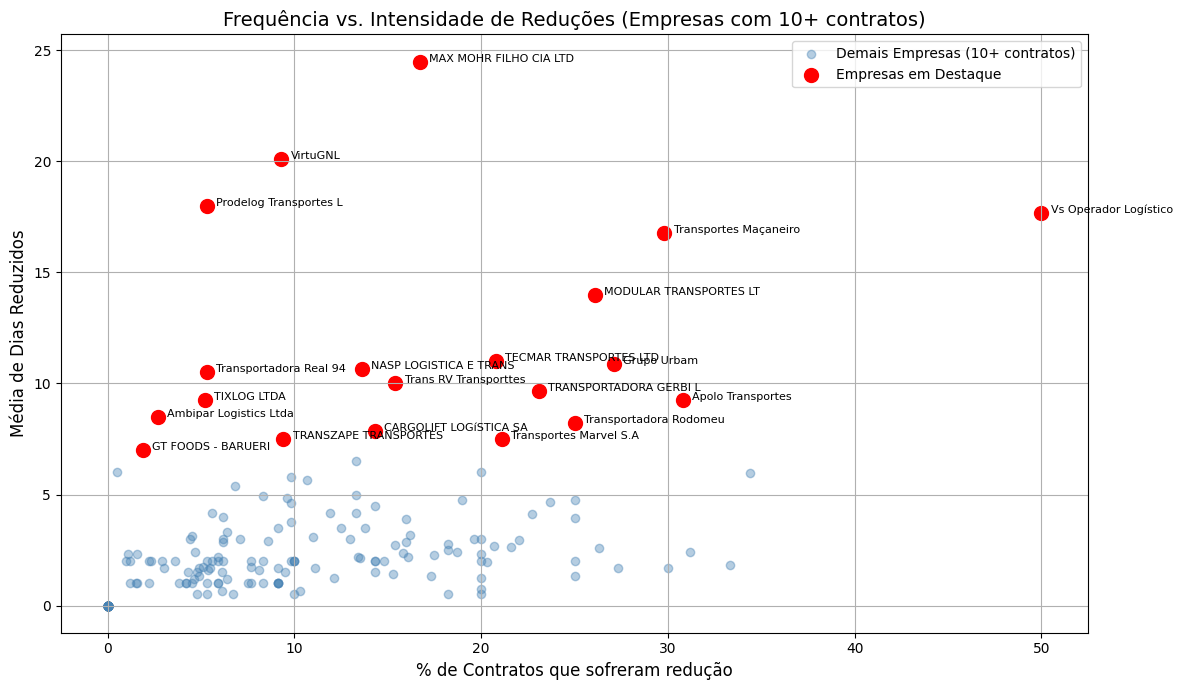

In [44]:
# 2. Calcular a média de dias reduzidos entre contratos que tiveram redução
resumo_filtrado["media_dias_reducao"] = (
    resumo_filtrado["total_dias_reducao"] / resumo_filtrado["com_reducao"]
).replace([float('inf'), -float('inf')], 0).fillna(0).round(2)

# 3. Selecionar os 20 destaques com maior média de dias reduzidos
destaques = resumo_filtrado.sort_values("media_dias_reducao", ascending=False).head(20)

# 4. Gerar o gráfico
plt.figure(figsize=(12, 7))

# Todos os pontos
plt.scatter(
    resumo_filtrado["porcentagem_reducao"],
    resumo_filtrado["media_dias_reducao"],
    color="steelblue",
    alpha=0.4,
    label="Demais Empresas (10+ contratos)"
)

# Destaques
plt.scatter(
    destaques["porcentagem_reducao"],
    destaques["media_dias_reducao"],
    color="red",
    edgecolor="red",
    s=100,
    label="Empresas em Destaque"
)

# Anotar os nomes das empresas destacadas
for _, row in destaques.iterrows():
    plt.text(
        row["porcentagem_reducao"] + 0.5,
        row["media_dias_reducao"],
        str(row["company_name"])[:22],
        fontsize=8
    )

# Estética
plt.title("Frequência vs. Intensidade de Reduções (Empresas com 10+ contratos)", fontsize=14)
plt.xlabel("% de Contratos que sofreram redução", fontsize=12)
plt.ylabel("Média de Dias Reduzidos", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


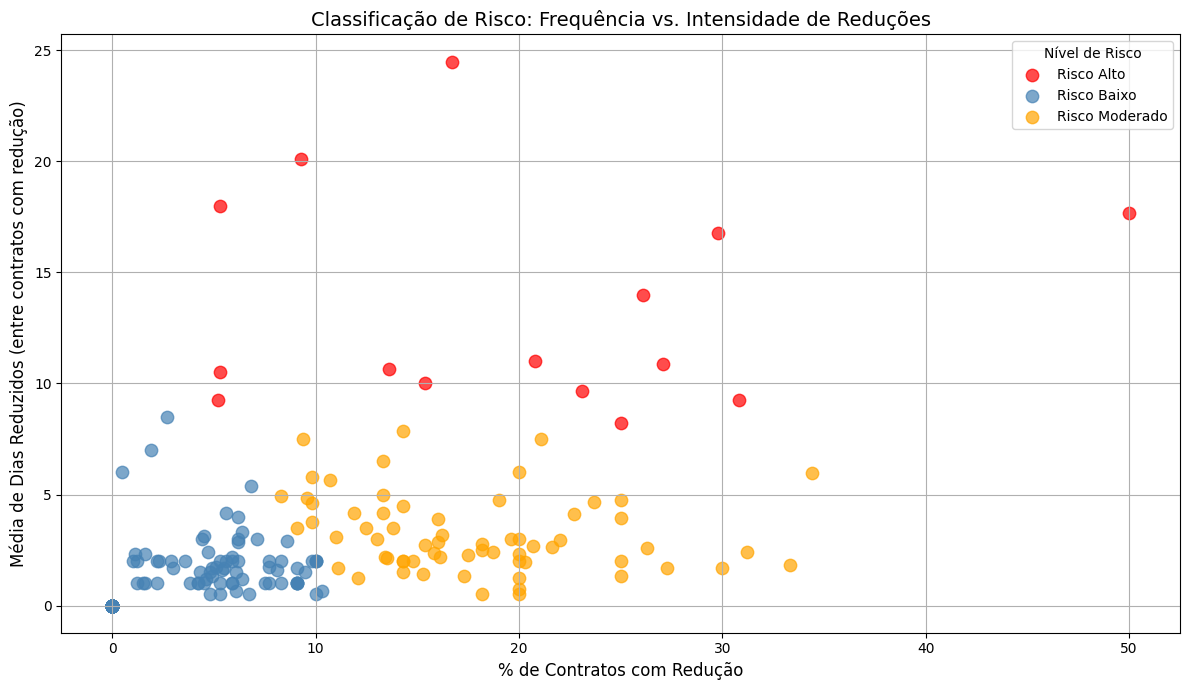

In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. Calcular a média de dias reduzidos entre os contratos com redução
resumo_final["media_dias_reducao"] = (
    resumo_final["total_dias_reducao"] / resumo_final["com_reducao"]
).replace([float("inf"), -float("inf")], 0).fillna(0).round(2)

# 2. Filtrar empresas com pelo menos 10 contratos
resumo_filtrado = resumo_final[resumo_final["total_contratos"] >= 10].copy()

# 3. Preparar dados para clusterização
X = resumo_filtrado[["porcentagem_reducao", "media_dias_reducao"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Aplicar KMeans com 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
resumo_filtrado["grupo_risco"] = kmeans.fit_predict(X_scaled)

# 5. Nomear os clusters como Baixo, Moderado, Alto
centros = scaler.inverse_transform(kmeans.cluster_centers_)
ordem_risco = centros[:, 0] + centros[:, 1]  # soma da frequência + intensidade
mapeamento = {i: risco for i, risco in zip(ordem_risco.argsort(), ["Baixo", "Moderado", "Alto"])}
resumo_filtrado["categoria_risco"] = resumo_filtrado["grupo_risco"].map(mapeamento)

# 6. Gerar gráfico com 3 cores por nível de risco
cores = {"Baixo": "steelblue", "Moderado": "orange", "Alto": "red"}

plt.figure(figsize=(12, 7))

for categoria, grupo_df in resumo_filtrado.groupby("categoria_risco"):
    plt.scatter(
        grupo_df["porcentagem_reducao"],
        grupo_df["media_dias_reducao"],
        label=f"Risco {categoria}",
        color=cores[categoria],
        edgecolor="red" if categoria == "Alto" else None,
        s=80,
        alpha=0.7
    )

plt.title("Classificação de Risco: Frequência vs. Intensidade de Reduções", fontsize=14)
plt.xlabel("% de Contratos com Redução", fontsize=12)
plt.ylabel("Média de Dias Reduzidos (entre contratos com redução)", fontsize=12)
plt.grid(True)
plt.legend(title="Nível de Risco")
plt.tight_layout()
plt.show()


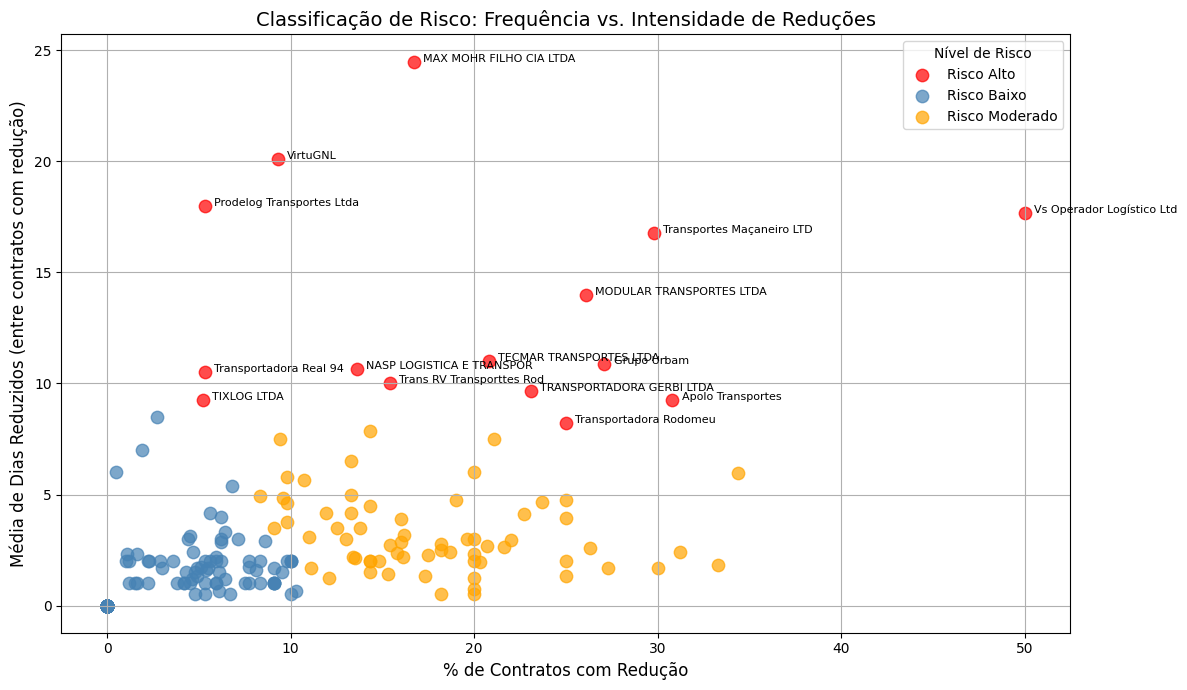

In [46]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Recalcular a métrica de intensidade média se necessário
resumo_final["media_dias_reducao"] = (
    resumo_final["total_dias_reducao"] / resumo_final["com_reducao"]
).replace([float("inf"), -float("inf")], 0).fillna(0).round(2)

# Filtrar empresas com pelo menos 10 contratos
resumo_filtrado = resumo_final[resumo_final["total_contratos"] >= 10].copy()

# Clusterização
X = resumo_filtrado[["porcentagem_reducao", "media_dias_reducao"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
resumo_filtrado["grupo_risco"] = kmeans.fit_predict(X_scaled)

# Nomear os grupos
centros = scaler.inverse_transform(kmeans.cluster_centers_)
ordem_risco = centros[:, 0] + centros[:, 1]
mapeamento = {i: risco for i, risco in zip(ordem_risco.argsort(), ["Baixo", "Moderado", "Alto"])}
resumo_filtrado["categoria_risco"] = resumo_filtrado["grupo_risco"].map(mapeamento)

# 🔴 Gerar o gráfico com nomes apenas para empresas de risco alto
cores = {"Baixo": "steelblue", "Moderado": "orange", "Alto": "red"}

plt.figure(figsize=(12, 7))

# Plotar todos os grupos com cores
for categoria, grupo_df in resumo_filtrado.groupby("categoria_risco"):
    plt.scatter(
        grupo_df["porcentagem_reducao"],
        grupo_df["media_dias_reducao"],
        color=cores[categoria],
        edgecolor="red" if categoria == "Alto" else None,
        s=80,
        alpha=0.7,
        label=f"Risco {categoria}"
    )

# Nomear apenas os pontos do grupo de risco alto
grupo_alto = resumo_filtrado[resumo_filtrado["categoria_risco"] == "Alto"]
for _, row in grupo_alto.iterrows():
    plt.text(
        row["porcentagem_reducao"] + 0.5,
        row["media_dias_reducao"],
        str(row["company_name"])[:25],
        fontsize=8
    )

plt.title("Classificação de Risco: Frequência vs. Intensidade de Reduções", fontsize=14)
plt.xlabel("% de Contratos com Redução", fontsize=12)
plt.ylabel("Média de Dias Reduzidos (entre contratos com redução)", fontsize=12)
plt.grid(True)
plt.legend(title="Nível de Risco")
plt.tight_layout()
plt.show()


In [47]:
resumo_filtrado

,company_id,company_name,total_contratos,com_reducao,sem_reducao,total_dias_reducao,porcentagem_reducao,media_dias_reducao,grupo_risco,categoria_risco
275,2103,FSJ - JANAINA,194,46,148,214.0,23.7,4.65,2,Moderado
277,2124,FSJ - JOÃO VICTOR,148,30,118,58.5,20.3,1.95,2,Moderado
138,953,TRANSDANIEL,303,29,274,140.0,9.6,4.83,2,Moderado
136,948,TECMAR TRANSPORTES LTDA - MATRIZ,130,27,103,297.5,20.8,11.02,1,Alto
30,249,TRANSPORTES TOZZO LTDA,209,23,186,71.0,11.0,3.09,2,Moderado
...,...,...,...,...,...,...,...,...,...,...
479,3783,Univale Distribuidora de Bebidas,10,0,10,0.0,0.0,0.00,0,Baixo
481,3822,IMPERIO BEBIDAS - Serra,41,0,41,0.0,0.0,0.00,0,Baixo
532,4150,DISTRIBUIDORA MENEGAZZO LTDA,11,0,11,0.0,0.0,0.00,0,Baixo
0,6,ACEVILLE TRANSPORTES LTDA,23,0,23,0.0,0.0,0.00,0,Baixo


In [48]:
# Agora calcular as características médias por grupo de risco
caracteristicas_risco = (
    resumo_filtrado.groupby("categoria_risco")
    .agg(
        media_total_contratos=("total_contratos", "mean"),
        media_contratos_com_reducao=("com_reducao", "mean"),
        media_porcentagem_reducao=("porcentagem_reducao", "mean"),
        media_dias_reducao=("media_dias_reducao", "mean"),
        empresas_no_grupo=("company_id", "count")
    )
    .round(1)
    .reset_index()
)

caracteristicas_risco.sort_values("categoria_risco", ascending=False)

,categoria_risco,media_total_contratos,media_contratos_com_reducao,media_porcentagem_reducao,media_dias_reducao,empresas_no_grupo
2,Moderado,59.1,9.1,17.6,3.2,65
1,Baixo,44.5,1.4,2.9,1.0,139
0,Alto,34.7,6.5,20.2,13.4,15


# ANÁLISE DO PERÍODO AVALIADO

In [49]:
import pandas as pd

# Contagem de contratos com redução (df_original)
contagem_original = (
    df_original
    .groupby(['periodo', 'tipo', 'nivel_px'])
    .agg(qt_freights_original=('freight_id', 'nunique'))
    .reset_index()
)

# Contagem de todos os contratos analisados (df_todos_retroativos)
contagem_retroativos = (
    df_todos_retroativos
    .groupby(['periodo', 'tipo', 'nivel_px'])
    .agg(qt_freights_retroativos=('freight_id', 'nunique'))
    .reset_index()
)

# Juntar as duas contagens por periodo, tipo e nivel_px
contagem_combinada = pd.merge(
    contagem_original,
    contagem_retroativos,
    on=['periodo', 'tipo', 'nivel_px'],
    how='outer'
)

# Preencher valores nulos com zero e garantir que são inteiros
contagem_combinada.fillna(0, inplace=True)
contagem_combinada[['qt_freights_original', 'qt_freights_retroativos']] = contagem_combinada[
    ['qt_freights_original', 'qt_freights_retroativos']
].astype(int)

# Calcular proporção de contratos com redução
contagem_combinada['proporcao_contratos_com_retroativos'] = (
    contagem_combinada['qt_freights_original'] / contagem_combinada['qt_freights_retroativos']
).round(4)

# Resultado final com as colunas relevantes
tabela_final = contagem_combinada[
    ['periodo', 'tipo', 'nivel_px', 'qt_freights_original', 'qt_freights_retroativos', 'proporcao_contratos_com_retroativos']
]

tabela_final


,periodo,tipo,nivel_px,qt_freights_original,qt_freights_retroativos,proporcao_contratos_com_retroativos
0,2025-02-01,Coleta/Entrega,Bronze,3,42,0.0714
1,2025-02-01,Coleta/Entrega,Diamante,7,185,0.0378
2,2025-02-01,Coleta/Entrega,Ouro,15,260,0.0577
3,2025-02-01,Coleta/Entrega,Prata,6,83,0.0723
4,2025-02-01,Diária,Bronze,4,26,0.1538
...,...,...,...,...,...,...
59,2025-04-11,Coleta/Entrega,Prata,4,68,0.0588
60,2025-04-11,Diária,Bronze,0,5,0.0000
61,2025-04-11,Diária,Diamante,7,92,0.0761
62,2025-04-11,Diária,Ouro,11,143,0.0769


In [ ]:
tabela_final.

In [50]:
print(contagem_combinada.periodo.min())
print(contagem_combinada.periodo.max())

2025-02-01 00:00:00
2025-04-11 00:00:00


Foi avaliado o período 01/02/2025 a 21/04/25.

Nesse intervalo, foram considerados intervalos de 10 dias para identificação de padrões de comportamento.

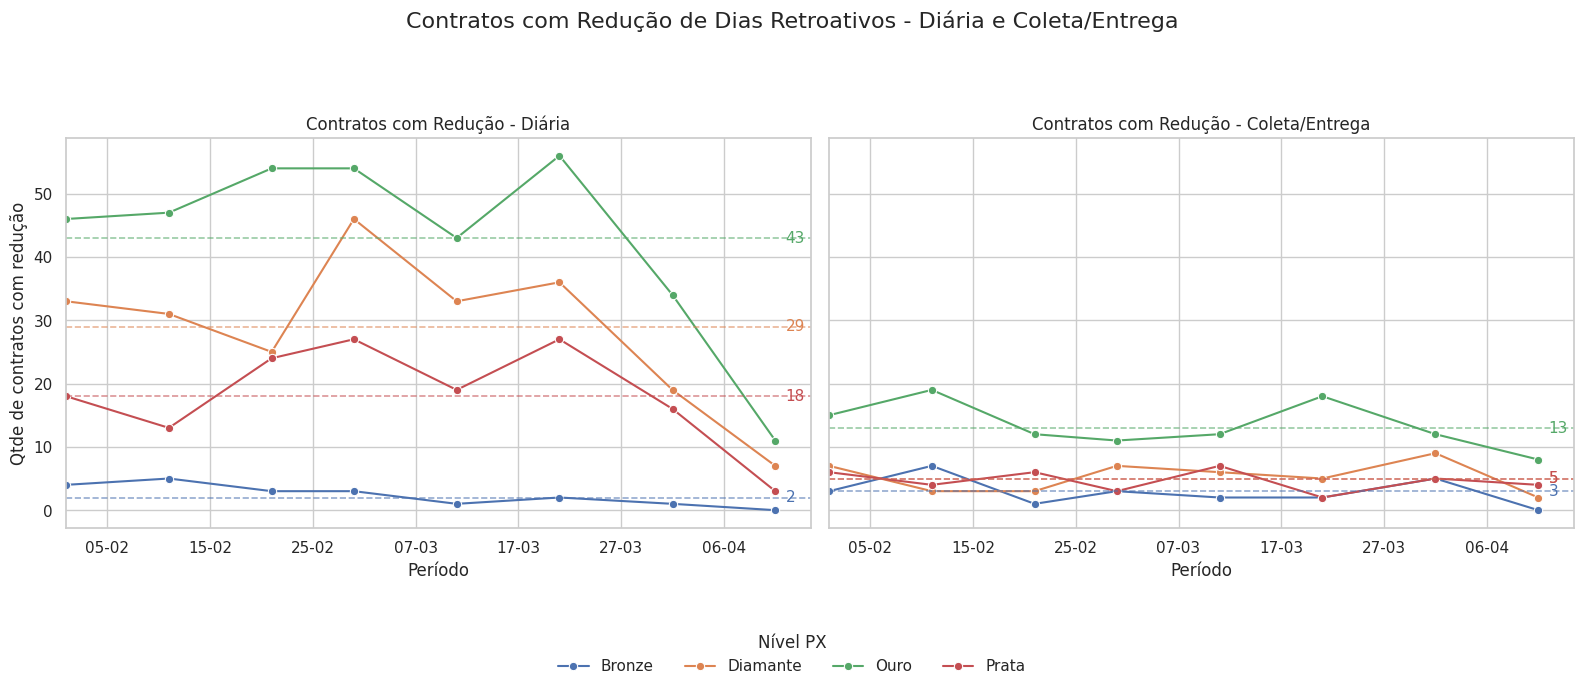

In [51]:
# Recriar gráfico com legenda correta no topo — removendo as internas e mantendo a global

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Estilo e figura
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

tipos_desejados = ['Diária', 'Coleta/Entrega']
cores_niveis = {}
handles_legenda, labels_legenda = None, None

for ax, tipo in zip(axes, tipos_desejados):
    dados_tipo = tabela_final[tabela_final['tipo'] == tipo]

    # Plot principal (com legenda apenas no primeiro gráfico para capturar os handles)
    plot = sns.lineplot(
        data=dados_tipo,
        x='periodo',
        y='qt_freights_original',
        hue='nivel_px',
        marker='o',
        ax=ax
    )

    # Capturar legendas apenas uma vez
    if handles_legenda is None:
        handles_legenda, labels_legenda = plot.get_legend_handles_labels()
    ax.legend_.remove()  # Remove legenda interna do subplot

    # Captura de cores
    for line, label in zip(plot.lines, dados_tipo['nivel_px'].unique()):
        if label not in cores_niveis:
            cores_niveis[label] = line.get_color()

    # Médias com anotação
    medias = (
        dados_tipo.groupby('nivel_px')['qt_freights_original']
        .mean()
        .round()
        .astype(int)
        .to_dict()
    )

    for nivel, media in medias.items():
        ax.axhline(
            y=media,
            linestyle='--',
            linewidth=1.2,
            color=cores_niveis[nivel],
            alpha=0.6
        )
        ax.text(
            dados_tipo['periodo'].max()+ pd.Timedelta(days=1),
            media,
            f"{media}",
            va='center',
            ha='left',
            color=cores_niveis[nivel],
            fontsize=11
        )

    # Eixo X com data formatada e intervalo correto
    ax.set_title(f'Contratos com Redução - {tipo}', fontsize=12)
    ax.set_xlabel("Período")
    ax.set_ylabel("Qtde de contratos com redução")
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.set_xlim(left=pd.Timestamp('2025-02-01'))

# Legenda única e visível
fig.legend(
    handles_legenda,
    labels_legenda,
    title="Nível PX",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),  # <- ajusta mais para baixo
    ncol=4,
    frameon=False
)

fig.suptitle("Contratos com Redução de Dias Retroativos - Diária e Coleta/Entrega", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


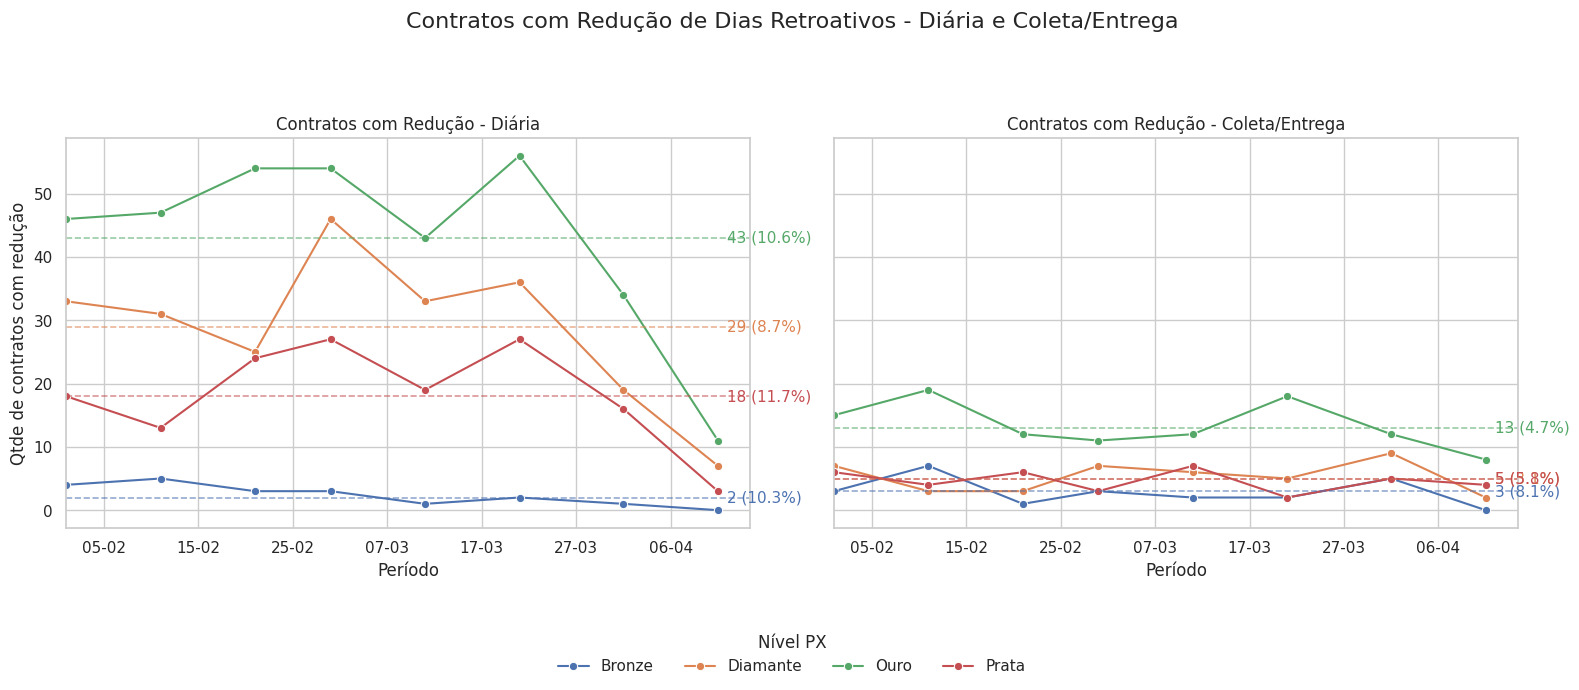

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd

# Estilo visual
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

tipos_desejados = ['Diária', 'Coleta/Entrega']
cores_niveis = {}
handles_legenda, labels_legenda = None, None

for ax, tipo in zip(axes, tipos_desejados):
    dados_tipo = tabela_final[tabela_final['tipo'] == tipo]

    # Linha principal
    plot = sns.lineplot(
        data=dados_tipo,
        x='periodo',
        y='qt_freights_original',
        hue='nivel_px',
        marker='o',
        ax=ax
    )

    # Pegar legenda apenas uma vez
    if handles_legenda is None:
        handles_legenda, labels_legenda = plot.get_legend_handles_labels()
    ax.legend_.remove()

    # Mapear cores dos níveis
    for line, label in zip(plot.lines, dados_tipo['nivel_px'].unique()):
        if label not in cores_niveis:
            cores_niveis[label] = line.get_color()

    # Médias absolutas
    medias = (
        dados_tipo.groupby('nivel_px')['qt_freights_original']
        .mean()
        .round()
        .astype(int)
        .to_dict()
    )

    # Médias percentuais
    medias_pct = (
        dados_tipo.groupby('nivel_px')['proporcao_contratos_com_retroativos']
        .mean()
        .mul(100)
        .round(1)
        .to_dict()
    )

    for nivel, media_abs in medias.items():
        media_pct = medias_pct.get(nivel, 0.0)
        texto = f"{media_abs} ({media_pct:.1f}%)"

        ax.axhline(
            y=media_abs,
            linestyle='--',
            linewidth=1.2,
            color=cores_niveis[nivel],
            alpha=0.6
        )
        ax.text(
            dados_tipo['periodo'].max() + pd.Timedelta(days=1),
            media_abs,
            texto,
            va='center',
            ha='left',
            color=cores_niveis[nivel],
            fontsize=11
        )

    # Configurações do eixo
    ax.set_title(f'Contratos com Redução - {tipo}', fontsize=12)
    ax.set_xlabel("Período")
    ax.set_ylabel("Qtde de contratos com redução")
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
    ax.set_xlim(left=pd.Timestamp('2025-02-01'))

# Legenda única
fig.legend(
    handles_legenda,
    labels_legenda,
    title="Nível PX",
    loc='lower center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,
    frameon=False
)

fig.suptitle("Contratos com Redução de Dias Retroativos - Diária e Coleta/Entrega", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


O gráfico apresenta a quantidade média de contratos com redução de dias retroativos ao longo do tempo, separada por tipo de contrato (Diária e Coleta/Entrega) e por nível PX (Bronze, Prata, Ouro, Diamante). Cada ponto representa a média registrada em um período de 10 dias, permitindo observar variações e tendências por perfil de contrato. As linhas tracejadas horizontais indicam a média geral de cada nível PX durante o período analisado, funcionando como uma referência visual para avaliar se determinados períodos ficaram acima ou abaixo do comportamento típico daquele grupo.

O comportamento dos contratos Diários mostra variações mais expressivas, especialmente nos níveis Ouro e Diamante, enquanto os contratos de Coleta/Entrega apresentaram maior estabilidade, com valores absolutos mais baixos e consistência entre os níveis. Esses padrões ajudam a identificar os perfis mais propensos a ajustes retroativos e podem apoiar decisões de monitoramento mais específico ou revisão de políticas operacionais.

In [52]:
import pandas as pd

# Supondo que 'tabela_final' já esteja carregada e contenha:
# ['tipo', 'nivel_px', 'periodo', 'qt_freights_original', 'qt_freights_retroativos']

# Etapa 1: Agregações a cada 10 dias por tipo e nível
total_reduzidos_nivel = (
    tabela_final
    .groupby(['tipo', 'nivel_px', 'periodo'])['qt_freights_original']
    .sum()
    .reset_index(name='qt_contratos_com_reducao')
)

total_geral_nivel = (
    tabela_final
    .groupby(['tipo', 'nivel_px', 'periodo'])['qt_freights_retroativos']
    .sum()
    .reset_index(name='qt_contratos_total')
)

tabela_taxa_nivel = pd.merge(total_reduzidos_nivel, total_geral_nivel, on=['tipo', 'nivel_px', 'periodo'])
tabela_taxa_nivel['proporcao'] = tabela_taxa_nivel['qt_contratos_com_reducao'] / tabela_taxa_nivel['qt_contratos_total']

# Etapa 2: Médias e projeções mensais
resumo_taxa_nivel = (
    tabela_taxa_nivel
    .groupby(['tipo', 'nivel_px'])
    .agg(
        media_contratos_com_reducao=('qt_contratos_com_reducao', 'mean'),
        media_contratos_total=('qt_contratos_total', 'mean'),
        media_proporcao=('proporcao', 'mean')
    )
    .reset_index()
)

resumo_taxa_nivel['estimado_mensal_reducao'] = (resumo_taxa_nivel['media_contratos_com_reducao'] * 3).round(0).astype(int)
resumo_taxa_nivel['estimado_mensal_total'] = (resumo_taxa_nivel['media_contratos_total'] * 3).round(0).astype(int)
resumo_taxa_nivel['estimado_mensal_percentual'] = (resumo_taxa_nivel['media_proporcao'] * 100).round(1)


In [54]:
resumo_taxa_nivel

,tipo,nivel_px,media_contratos_com_reducao,media_contratos_total,media_proporcao,estimado_mensal_reducao,estimado_mensal_total,estimado_mensal_percentual
0,Coleta/Entrega,Bronze,2.875,32.250,0.080792,9,97,8.1
1,Coleta/Entrega,Diamante,5.250,170.000,0.030563,16,510,3.1
2,Coleta/Entrega,Ouro,13.375,283.500,0.046782,40,850,4.7
3,Coleta/Entrega,Prata,4.625,80.500,0.058001,14,242,5.8
4,Diária,Bronze,2.375,19.875,0.102940,7,60,10.3
5,Diária,Diamante,28.750,325.375,0.086886,86,976,8.7
6,Diária,Ouro,43.125,399.625,0.105965,129,1199,10.6
7,Diária,Prata,18.375,151.625,0.117266,55,455,11.7


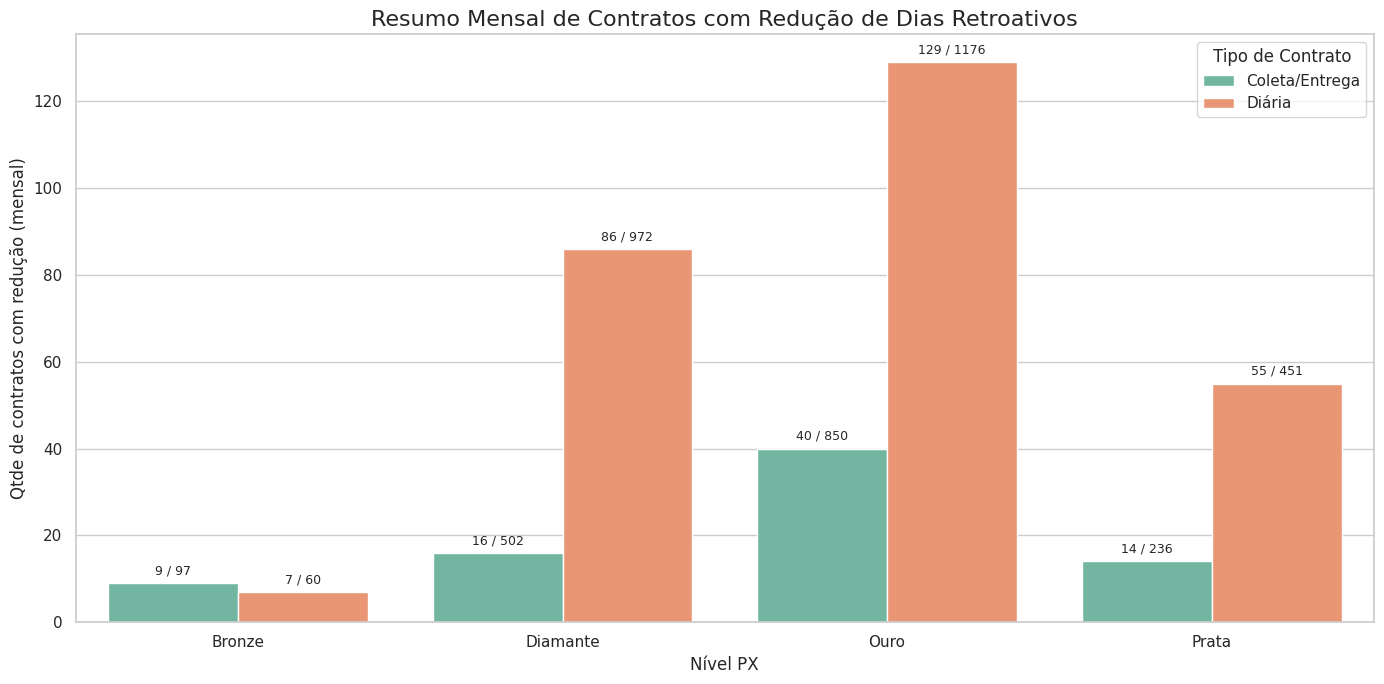

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.barplot(
    data=resumo_taxa_nivel,
    x='nivel_px',
    y='estimado_mensal_reducao',
    hue='tipo',
    palette='Set2'
)

# Adiciona rótulos com valores totais por grupo
for i, row in resumo_taxa_nivel.iterrows():
    x_pos = list(resumo_taxa_nivel['nivel_px'].unique()).index(row['nivel_px']) + (0.2 if row['tipo'] == 'Diária' else -0.2)
    plt.text(
        x=x_pos,
        y=row['estimado_mensal_reducao'] + 2,
        s=f"{row['estimado_mensal_reducao']} / {row['estimado_mensal_total']}",
        ha='center',
        fontsize=9
    )

plt.title("Resumo Mensal de Contratos com Redução de Dias Retroativos", fontsize=16)
plt.ylabel("Qtde de contratos com redução (mensal)")
plt.xlabel("Nível PX")
plt.legend(title="Tipo de Contrato")
plt.tight_layout()
plt.show()


In [ ]:
# Adiciona uma coluna com texto para relatório
resumo_taxa_nivel['resumo'] = resumo_taxa_nivel.apply(
    lambda row: (
        f"No nível {row['nivel_px']} do tipo {row['tipo']}, estima-se que {row['estimado_mensal_reducao']}\n "
        f"dos {row['estimado_mensal_total']} contratos mensais sofram redução de dias retroativos,"
        f"representando {row['estimado_mensal_percentual']}% do total."
    ),
    axis=1
)

# Imprimir parágrafos prontos
for texto in resumo_taxa_nivel['resumo']:
    print(texto)

No nível Bronze do tipo Coleta/Entrega, estima-se que 9
 dos 97 contratos mensais sofram redução de dias retroativos,representando 8.1% do total.
No nível Diamante do tipo Coleta/Entrega, estima-se que 16
 dos 502 contratos mensais sofram redução de dias retroativos,representando 3.1% do total.
No nível Ouro do tipo Coleta/Entrega, estima-se que 40
 dos 850 contratos mensais sofram redução de dias retroativos,representando 4.7% do total.
No nível Prata do tipo Coleta/Entrega, estima-se que 14
 dos 236 contratos mensais sofram redução de dias retroativos,representando 6.0% do total.
No nível Bronze do tipo Diária, estima-se que 7
 dos 60 contratos mensais sofram redução de dias retroativos,representando 10.1% do total.
No nível Diamante do tipo Diária, estima-se que 86
 dos 972 contratos mensais sofram redução de dias retroativos,representando 8.9% do total.
No nível Ouro do tipo Diária, estima-se que 129
 dos 1176 contratos mensais sofram redução de dias retroativos,representando 10.9%

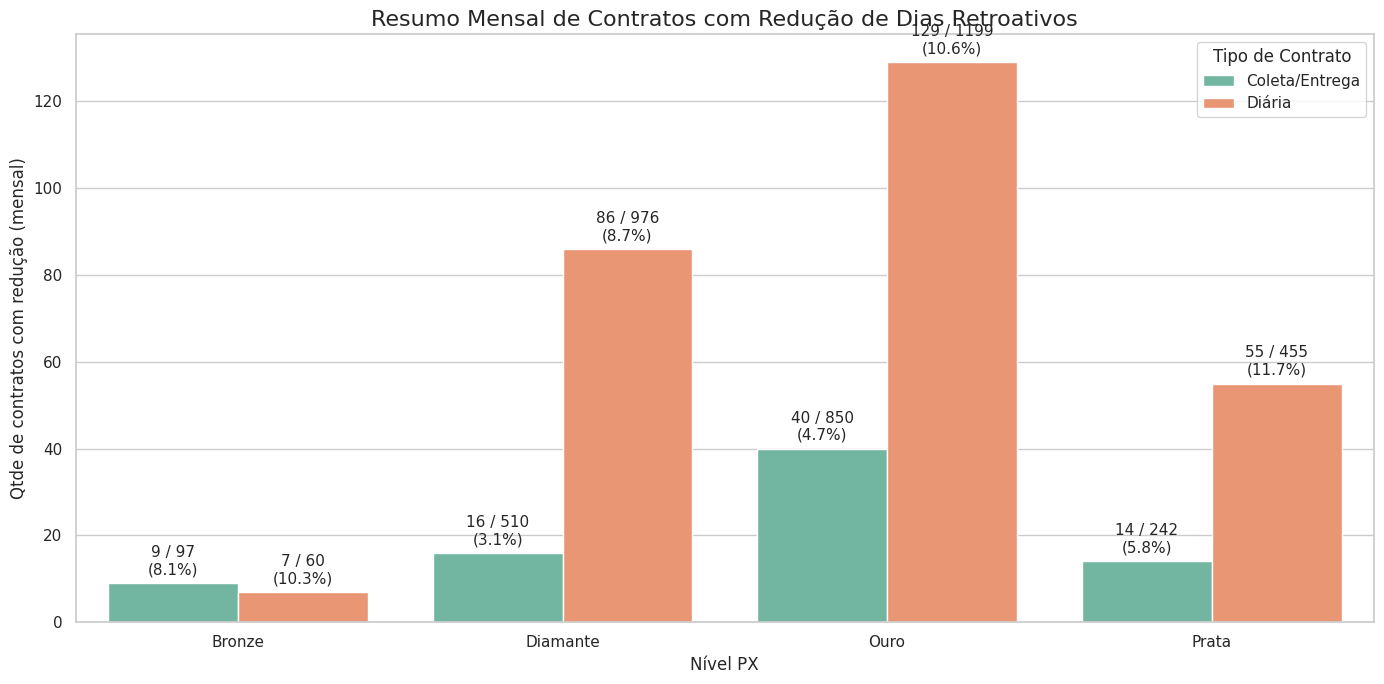

In [57]:
# Recriar o DataFrame resumo_taxa_nivel manualmente com base na estrutura fornecida

import pandas as pd

resumo_taxa_nivel = pd.DataFrame({
    'tipo': [
        'Coleta/Entrega', 'Coleta/Entrega', 'Coleta/Entrega', 'Coleta/Entrega',
        'Diária', 'Diária', 'Diária', 'Diária'
    ],
    'nivel_px': [
        'Bronze', 'Diamante', 'Ouro', 'Prata',
        'Bronze', 'Diamante', 'Ouro', 'Prata'
    ],
    'media_contratos_com_reducao': [2.875, 5.250, 13.375, 4.625, 2.375, 28.750, 43.125, 18.375],
    'media_contratos_total': [32.250, 170.000, 283.500, 80.500, 19.875, 325.375, 399.625, 151.625],
    'media_proporcao': [0.080792, 0.030563, 0.046782, 0.058001, 0.102940, 0.086886, 0.105965, 0.117266],
    'estimado_mensal_reducao': [9, 16, 40, 14, 7, 86, 129, 55],
    'estimado_mensal_total': [97, 510, 850, 242, 60, 976, 1199, 455],
    'estimado_mensal_percentual': [8.1, 3.1, 4.7, 5.8, 10.3, 8.7, 10.6, 11.7]
})

# Gerar o gráfico com rótulos contendo valor absoluto + percentual
plt.figure(figsize=(14, 7))
sns.barplot(
    data=resumo_taxa_nivel,
    x='nivel_px',
    y='estimado_mensal_reducao',
    hue='tipo',
    palette='Set2'
)

# Adicionar rótulos com valor absoluto + percentual
for i, row in resumo_taxa_nivel.iterrows():
    deslocamento = 0.2 if row['tipo'] == 'Diária' else -0.2
    x_pos = list(resumo_taxa_nivel['nivel_px'].unique()).index(row['nivel_px']) + deslocamento

    texto = f"{int(row['estimado_mensal_reducao'])} / {int(row['estimado_mensal_total'])}\n({row['estimado_mensal_percentual']:.1f}%)"
    
    plt.text(
        x=x_pos,
        y=row['estimado_mensal_reducao'] + 2,
        s=texto,
        ha='center',
        fontsize=11
    )

plt.title("Resumo Mensal de Contratos com Redução de Dias Retroativos", fontsize=16)
plt.ylabel("Qtde de contratos com redução (mensal)")
plt.xlabel("Nível PX")
plt.legend(title="Tipo de Contrato")
plt.tight_layout()
plt.show()


Durante o período avaliado, foi possível estimar a média mensal de contratos realizados e daqueles que passaram por redução retroativa de dias, segmentando por tipo de contrato (Diária e Coleta/Entrega) e nível PX (Bronze, Prata, Ouro, Diamante). As estimativas têm como base médias apuradas a cada 10 dias, posteriormente projetadas para o mês por meio de multiplicação por três — uma abordagem que reflete um cenário operacional típico.

Os contratos do tipo Diária apresentaram, de forma geral, os maiores percentuais de redução. Destaque para o nível Prata, com 11,1% dos contratos mensais sofrendo redução (51 de 451), seguido de perto por Ouro com 10,5% (125 de 1176), e Bronze com 10,1% (7 de 60). Esses resultados indicam que os contratos Diários, especialmente nos níveis mais operacionais, estão mais suscetíveis a ajustes retroativos — possivelmente pela natureza mais rotativa, informal ou de menor controle desses serviços.

Nos contratos do tipo Coleta/Entrega, o comportamento foi mais estável, porém com variações relevantes. O nível Bronze apresentou 8,1% de redução (9 de 97 contratos), enquanto o nível Prata teve 5,6% (13 de 236). Já os níveis mais elevados apresentaram as menores taxas: Ouro com 4,2% (36 de 850) e Diamante com apenas 2,8% (14 de 502) — o menor índice de todos os grupos avaliados.

Esses padrões reforçam que a probabilidade de redução retroativa de dias está fortemente associada ao tipo e ao nível do contrato, sendo mais expressiva entre os contratos Diários e em níveis PX mais baixos. Tais informações podem orientar ações preventivas, como maior rigor nos critérios de qualificação de prestadores, reforço nos mecanismos de controle e acompanhamento das entregas, especialmente nas faixas com maior vulnerabilidade a inconsistências operacionais.

# ANALISE DIAS RETROATIVOS REMOVIDOS

A partir da base de contratos finalizados com informações sobre os dias contratados e os dias efetivamente trabalhados, foi calculado o risco estimado de um contrato sofrer redução de dias após a solicitação de adiantamento. Para tornar essa estimativa mais robusta, utilizamos uma abordagem Bayesiana com suavização spline, o que permite considerar o comportamento geral da base mesmo em casos com poucos dados. A função resultante estima o risco com base na proporção cumprida do contrato no momento da antecipação. Em seguida, para cada duração de contrato, foi aplicada uma técnica inspirada no método do cotovelo para identificar o ponto crítico da curva de risco — chamado de dia_virada — que indica o dia mínimo recomendado para solicitar adiantamento com risco estabilizado.

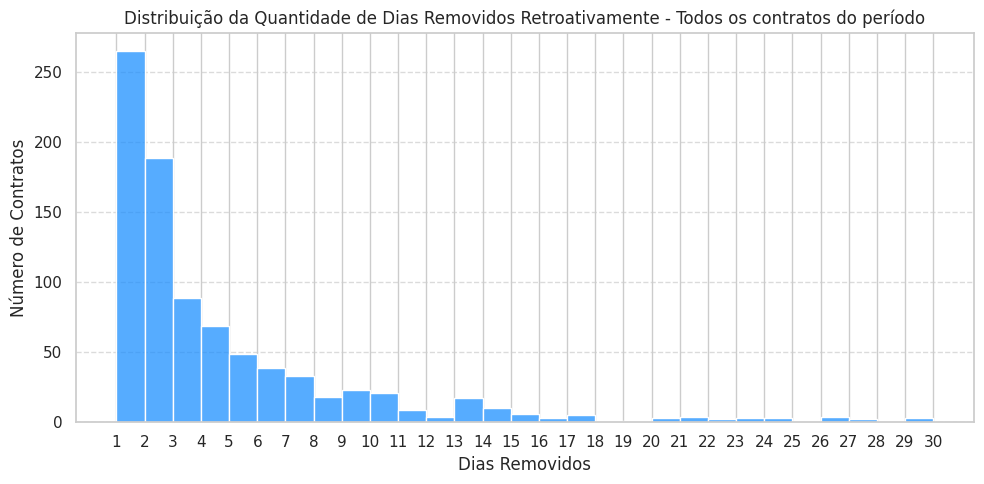

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que você tenha uma coluna chamada 'dias_reducao' no DataFrame com os dias efetivamente removidos
# E que você esteja trabalhando com df_todos_retroativos ou um DataFrame similar

plt.figure(figsize=(10, 5))
sns.histplot(df_original['dias_reducao'], bins=range(1, 31), kde=False, color='dodgerblue')

plt.title('Distribuição da Quantidade de Dias Removidos Retroativamente - Todos os contratos do período')
plt.xlabel('Dias Removidos')
plt.ylabel('Número de Contratos')
plt.xticks(range(1, 31, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
df_original.describe()

,periodo,freight_id,contract_days_inicial,dias_reducao
count,970,970.000000,970.000000,970.000000
mean,2025-03-02 16:18:18.556700928,148007.538144,13.674227,4.090722
min,2025-02-01 00:00:00,139326.000000,1.500000,0.500000
25%,2025-02-11 00:00:00,143601.250000,6.000000,1.000000
50%,2025-03-01 00:00:00,147669.000000,11.000000,2.000000
75%,2025-03-21 00:00:00,152221.000000,19.000000,5.000000
max,2025-04-11 00:00:00,159082.000000,63.000000,32.000000
std,NaN,5280.167969,9.567238,4.944325


In [60]:
#  eliminando outliers

q1 = df_original['dias_reducao'].quantile(0.25)
q3 = df_original['dias_reducao'].quantile(0.75)
iqr = q3 - q1

limite_inferior = q1 - 2 * iqr
limite_superior = q3 + 2 * iqr

df_original = df_original[
    (df_original['dias_reducao'] >= limite_inferior) &
    (df_original['dias_reducao'] <= limite_superior)]

df_original

,periodo,freight_id,tipo,nivel_px,contract_days_inicial,dias_reducao
0,2025-04-11,159082,Coleta/Entrega,Prata,4.0,2.0
1,2025-04-11,159066,Coleta/Entrega,Ouro,3.0,2.0
2,2025-04-11,159056,Diária,Diamante,1.5,0.5
4,2025-04-11,158876,Diária,Diamante,13.0,8.0
5,2025-04-11,158809,Diária,Diamante,4.0,1.0
...,...,...,...,...,...,...
964,2025-02-01,139378,Coleta/Entrega,Diamante,23.0,8.0
965,2025-02-01,139359,Coleta/Entrega,Diamante,8.0,1.0
966,2025-02-01,139352,Coleta/Entrega,Ouro,3.0,1.0
968,2025-02-01,139344,Diária,Diamante,28.0,6.0


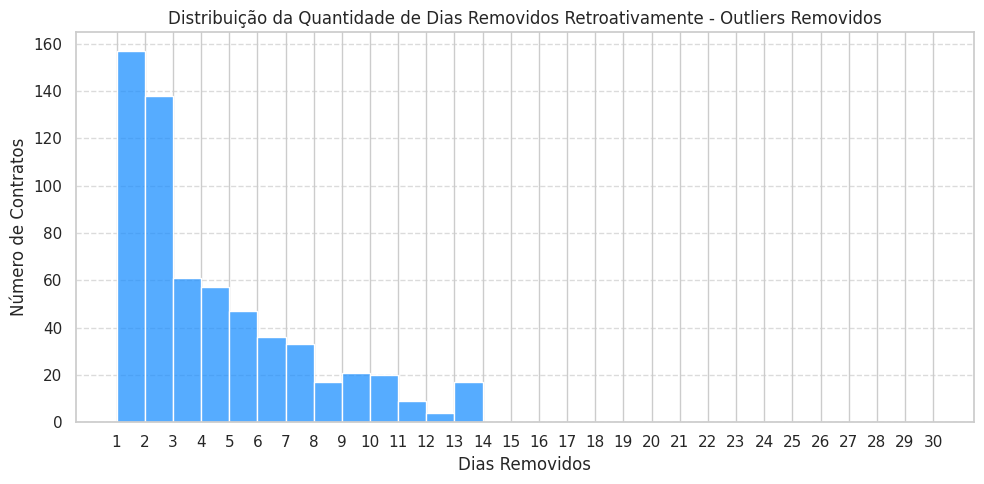

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que você tenha uma coluna chamada 'dias_reducao' no DataFrame com os dias efetivamente removidos
# E que você esteja trabalhando com df_todos_retroativos ou um DataFrame similar

df_original = df_original.loc[(df_original.nivel_px != 'Bronze')&(df_original.contract_days_inicial > 5)]
plt.figure(figsize=(10, 5))
sns.histplot(df_original['dias_reducao'], bins=range(1, 31), kde=False, color='dodgerblue')

plt.title('Distribuição da Quantidade de Dias Removidos Retroativamente - Outliers Removidos')
plt.xlabel('Dias Removidos')
plt.ylabel('Número de Contratos')
plt.xticks(range(1, 31, 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [65]:
df_original.describe()

,periodo,freight_id,contract_days_inicial,dias_reducao
count,694,694.000000,694.000000,694.000000
mean,2025-03-01 02:54:17.636887552,147606.997118,15.701009,3.578530
min,2025-02-01 00:00:00,139326.000000,5.500000,0.500000
25%,2025-02-11 00:00:00,143486.500000,9.500000,1.000000
50%,2025-03-01 00:00:00,147248.500000,13.000000,2.000000
75%,2025-03-21 00:00:00,151614.000000,20.000000,5.000000
max,2025-04-11 00:00:00,158876.000000,50.000000,13.000000
std,NaN,5045.225146,8.754896,3.162727


In [ ]:
# criando df_todos

reduzidos = df_original[['freight_id', 'tipo', 'nivel_px', 'contract_days_inicial','dias_reducao']].copy()
todos = df_todos_retroativos[['freight_id', 'tipo', 'nivel_px', 'contract_days']].copy()

df_todos = pd.merge(todos,reduzidos,
    on=['freight_id', 'tipo', 'nivel_px'],
    how='left')


df_todos.loc[df_todos['contract_days_inicial'].isna(), 'contract_days_inicial'] = df_todos['contract_days']

df_todos['dias_reducao'] = df_todos['dias_reducao'].fillna(0)

df_todos['houve_reducao'] = df_todos['dias_reducao'] != 0

df_todos = df_todos.loc[df_todos.contract_days_inicial > 0] 

# Criar variável de proporção de redução (evitar divisão por zero)
df_todos['proporcao_reducao'] = df_todos.apply(
    lambda row: row['dias_reducao'] / row['contract_days_inicial'] if row['contract_days_inicial'] > 0 else 0,
    axis=1).round(4)

df_todos = df_todos[['tipo', 'nivel_px', 'houve_reducao', "contract_days_inicial","dias_reducao",'proporcao_reducao']]

df_todos.to_csv("src/data/df_todos.csv")

df_todos


,tipo,nivel_px,houve_reducao,contract_days_inicial,dias_reducao,proporcao_reducao
0,Diária,Ouro,False,3.0,0.0,0.0000
1,Coleta/Entrega,Diamante,False,7.0,0.0,0.0000
2,Diária,Ouro,True,15.0,4.0,0.2667
3,Diária,Ouro,False,7.0,0.0,0.0000
4,Coleta/Entrega,Diamante,False,1.0,0.0,0.0000
...,...,...,...,...,...,...
11604,Diária,Diamante,False,1.0,0.0,0.0000
11605,Coleta/Entrega,Diamante,False,1.0,0.0,0.0000
11606,Coleta/Entrega,Diamante,False,1.0,0.0,0.0000
11607,Coleta/Entrega,Prata,False,1.0,0.0,0.0000


In [ ]:
df_todos.(dias_inicial == 1)

In [ ]:
# calculo do risco_bruto

df_todos['contract_days_inicial'] = df_todos['contract_days_inicial'].round(0).astype(int)
df_todos['dias_reducao'] = df_todos['dias_reducao'].fillna(0).round(0).astype(int)

# Gerar risco bruto para dias_reducao de 1 a 20
resultados_risco = []

for dia_alvo in range(1, 21):
    grupos = df_todos.groupby(['tipo', 'nivel_px', 'contract_days_inicial'])
    
    for (tipo, nivel, duracao), grupo in grupos:
        total = len(grupo)
        if total == 0:
            continue

        risco = (grupo['dias_reducao'] >= dia_alvo).sum() / total

        resultados_risco.append({
            'tipo': tipo,
            'nivel_px': nivel,
            'contract_days_inicial': duracao,
            'dias_reducao_alvo': dia_alvo,
            'risco_estimado_bruto': round(risco, 4),
            'n_total': total
        })

df_risco_bruto = pd.DataFrame(resultados_risco)
df_risco_bruto.to_csv("src/data/df_risco_bruto.csv")
df_risco_bruto

,tipo,nivel_px,contract_days_inicial,dias_reducao_alvo,risco_estimado_bruto,n_total
0,Coleta/Entrega,Bronze,1,1,0.0000,91
1,Coleta/Entrega,Bronze,2,1,0.0938,32
2,Coleta/Entrega,Bronze,3,1,0.1111,36
3,Coleta/Entrega,Bronze,4,1,0.1818,22
4,Coleta/Entrega,Bronze,5,1,0.1667,30
...,...,...,...,...,...,...
5835,Diária,Prata,42,20,0.0000,1
5836,Diária,Prata,43,20,0.0000,1
5837,Diária,Prata,45,20,0.0000,2
5838,Diária,Prata,49,20,0.0000,1


In [ ]:
# Calcular o risco bayesiano com alpha=10 e p0 variável por dias_reducao_alvo
alpha = 10

# Calcular p0 (prior) para cada valor de dias_reducao_alvo
p0_dict = {}
total_geral = len(df_todos)

for dia_alvo in range(1, 21):
    p0_dict[dia_alvo] = (df_todos['dias_reducao'] >= dia_alvo).sum() / total_geral

# Adicionar coluna de risco bayesiano ao df_risco_bruto
df_risco_bruto['risco_estimado_bayesiano'] = df_risco_bruto.apply(
    lambda row: round(
        (row['risco_estimado_bruto'] * row['n_total'] + alpha * p0_dict[row['dias_reducao_alvo']]) / (row['n_total'] + alpha),
        4
    ),
    axis=1
)

df_risco_bruto = df_risco_bruto.loc[df_risco_bruto.contract_days_inicial > df_risco_bruto.dias_reducao_alvo]
df_risco_bruto.head(10)


,tipo,nivel_px,contract_days_inicial,dias_reducao_alvo,risco_estimado_bruto,n_total,risco_estimado_bayesiano
1,Coleta/Entrega,Bronze,2,1,0.0938,32,0.0877
2,Coleta/Entrega,Bronze,3,1,0.1111,36,0.1017
3,Coleta/Entrega,Bronze,4,1,0.1818,22,0.1463
4,Coleta/Entrega,Bronze,5,1,0.1667,30,0.1420
5,Coleta/Entrega,Bronze,6,1,0.1111,18,0.0957
6,Coleta/Entrega,Bronze,7,1,0.3333,6,0.1675
7,Coleta/Entrega,Bronze,8,1,0.2500,4,0.1201
8,Coleta/Entrega,Bronze,9,1,0.0000,5,0.0454
9,Coleta/Entrega,Bronze,10,1,0.3333,3,0.1293
10,Coleta/Entrega,Bronze,11,1,0.2000,5,0.1121


/tmp/ipykernel_8904/3521423981.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: np.average(x['risco_estimado_bayesiano'], weights=x['n_total']))


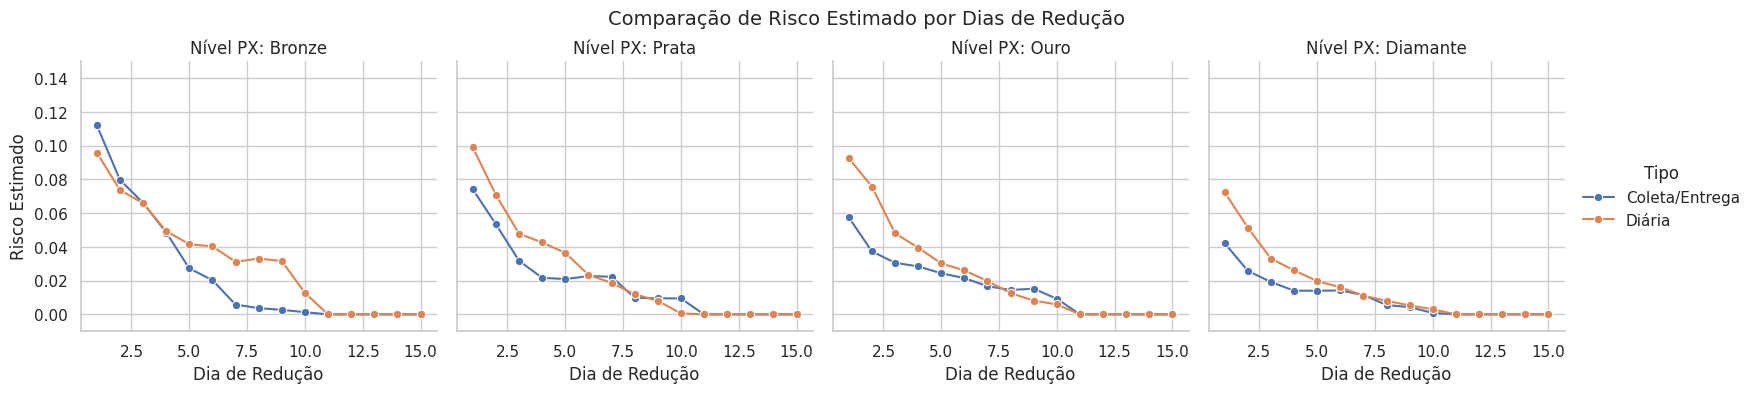

In [ ]:
# Regerar gráfico com grid (atualizando a versão enviada pelo usuário)
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupamento por nível, tipo e dias alvo — média ponderada bayesiana
df_plot1 = (
    df_risco_bruto[df_risco_bruto['dias_reducao_alvo'] <= 15]
    .groupby(['nivel_px', 'tipo', 'dias_reducao_alvo'])
    .apply(lambda x: np.average(x['risco_estimado_bayesiano'], weights=x['n_total']))
    .reset_index(name='risco_medio_ponderado')
)

# Ordem fixa dos níveis
ordem_niveis = ['Bronze', 'Prata', 'Ouro', 'Diamante']
df_plot1['nivel_px'] = pd.Categorical(df_plot1['nivel_px'], categories=ordem_niveis, ordered=True)

# Gráfico com linhas de grade
g1 = sns.FacetGrid(df_plot1, col="nivel_px", col_wrap=4, height=4, sharey=True)
g1.map_dataframe(sns.lineplot, x="dias_reducao_alvo", y="risco_medio_ponderado", hue="tipo", marker='o')
g1.set_titles("Nível PX: {col_name}")
g1.set_axis_labels("Dia de Redução", "Risco Estimado")
g1.set(ylim=(-0.01, 0.15))
g1.add_legend(title="Tipo")

# Adicionar grid manualmente para cada subplot
for ax in g1.axes.flat:
    ax.grid(True)

g1.fig.suptitle("Comparação de Risco Estimado por Dias de Redução", fontsize=14)
plt.subplots_adjust(top=0.85)
plt.show()




### Contratos tipo "Diária" apresentam mais risco que "Coleta/Entrega" em todos os níveis PX ###

A linha laranja está consistentemente acima da azul em todos os subgráficos.

Isso indica que contratos do tipo Diária têm maior probabilidade de sofrer redução , mesmo com poucos dias de contrato.

### O risco cai rapidamente nos primeiros dias ###

Para ambos os tipos de contrato, a maior queda no risco ocorre entre os dias 1 e 3.

Após isso, o risco se estabiliza ou reduz mais lentamente, o que pode indicar que a maioria das reduções acontece no início do contrato.

### Diferenças entre níveis PX são pequenas em escala <10% ###

Embora Bronze e Prata tenham risco um pouco mais alto no início, todos os níveis PX convergem para risco abaixo de 2% após o dia 6-7.

Isso sugere que nível PX influencia mais o risco no início do contrato.



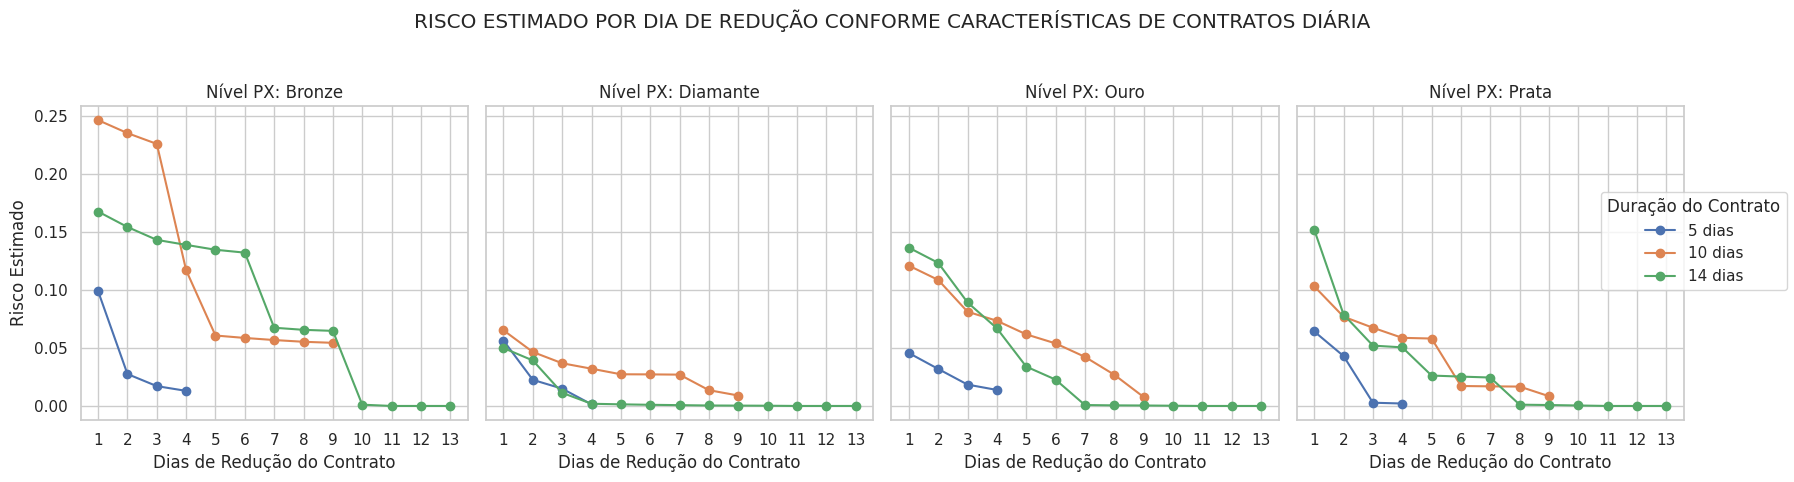

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Durações desejadas
duracoes_plot = [5, 10, 14]

# Filtrar apenas contratos do tipo "Diária"
df_diaria = df_risco_bruto[
    (df_risco_bruto['tipo'] == 'Diária') &
    (df_risco_bruto['contract_days_inicial'].isin(duracoes_plot))
]

# Listar níveis PX disponíveis
niveis_px_disponiveis = df_diaria['nivel_px'].unique()

# Criar gráfico por nível PX
fig, axs = plt.subplots(1, len(niveis_px_disponiveis), figsize=(18, 5), sharey=True)

# Armazenar handles/labels para uma única legenda
handles_legenda = []
labels_legenda = []

for ax, nivel in zip(axs, niveis_px_disponiveis):
    df_nivel = df_diaria[df_diaria['nivel_px'] == nivel]
    for duracao in duracoes_plot:
        dados = df_nivel[df_nivel['contract_days_inicial'] == duracao].sort_values('dias_reducao_alvo')
        linha, = ax.plot(
            dados['dias_reducao_alvo'],
            dados['risco_estimado_bayesiano'],
            marker='o',
            label=f'{duracao} dias'
        )
        if f'{duracao} dias' not in labels_legenda:
            handles_legenda.append(linha)
            labels_legenda.append(f'{duracao} dias')
    ax.set_title(f'Nível PX: {nivel}')
    ax.set_xlabel('Dias de Redução do Contrato')
    ax.grid(True)
    ax.xaxis.set_major_locator(MultipleLocator(1))  # ✅ Eixo X com apenas inteiros

# Eixo Y
axs[0].set_ylabel('Risco Estimado')

# Título e legenda final
fig.suptitle('RISCO ESTIMADO POR DIA DE REDUÇÃO CONFORME CARACTERÍSTICAS DE CONTRATOS DIÁRIA')
fig.legend(handles=handles_legenda, labels=labels_legenda, title='Duração do Contrato', loc='center right')


plt.tight_layout(rect=[0, 0.02, 0.95, 0.95])
plt.show()


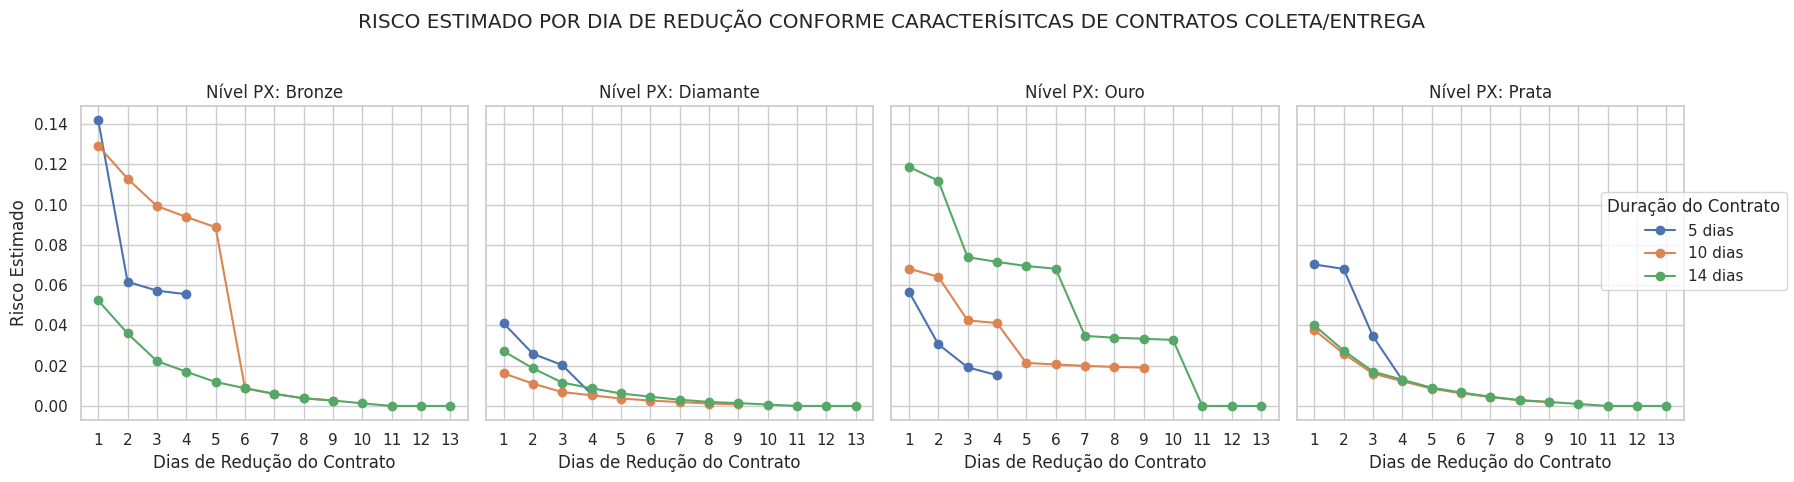

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Duracoes desejadas para traçar
duracoes_plot = [5, 10, 14]

# Filtrar apenas contratos do tipo "Coleta/Entrega" para essas durações
df_coleta = df_risco_bruto[
    (df_risco_bruto['tipo'] == 'Coleta/Entrega') &
    (df_risco_bruto['contract_days_inicial'].isin(duracoes_plot))
]

# Listar níveis PX disponíveis
niveis_px_disponiveis = df_coleta['nivel_px'].unique()

# Gerar um gráfico por nível PX
fig, axs = plt.subplots(1, len(niveis_px_disponiveis), figsize=(18, 5), sharey=True)

handles_legenda = []
labels_legenda = []

for ax, nivel in zip(axs, niveis_px_disponiveis):
    df_nivel = df_coleta[df_coleta['nivel_px'] == nivel]
    for duracao in duracoes_plot:
        dados = df_nivel[df_nivel['contract_days_inicial'] == duracao].sort_values('dias_reducao_alvo')
        linha, = ax.plot(
            dados['dias_reducao_alvo'],
            dados['risco_estimado_bayesiano'],
            marker='o',
            label=f'{duracao} dias'
        )
        if f'{duracao} dias' not in labels_legenda:
            handles_legenda.append(linha)
            labels_legenda.append(f'{duracao} dias')
    ax.set_title(f'Nível PX: {nivel}')
    ax.set_xlabel('Dias de Redução do Contrato')
    ax.grid(True)
    ax.xaxis.set_major_locator(MultipleLocator(1))  # 🔧 Força inteiros no eixo X

axs[0].set_ylabel('Risco Estimado')
fig.suptitle('RISCO ESTIMADO POR DIA DE REDUÇÃO CONFORME CARACTERÍSITCAS DE CONTRATOS COLETA/ENTREGA')
fig.legend(handles=handles_legenda, labels=labels_legenda, title='Duração do Contrato', loc='center right')


plt.tight_layout(rect=[0, 0.02, 0.95, 0.95])
plt.show()



Os gráficos exibem o risco estimado de redução de dias em contratos PX, separados por tipo de contrato — Diária (primeiro gráfico) e Coleta/Entrega (segundo gráfico) — e por nível PX (Bronze, Prata, Ouro, Diamante). Cada linha representa a evolução do risco conforme aumentam os dias de redução, diferenciando as curvas para contratos de 5, 10, 15 e 20 dias de duração inicial. Quanto maior o número de dias reduzidos, menor tende a ser o risco, refletindo uma curva decrescente. No entanto, a taxa de queda e a forma da curva variam entre níveis e tipos, revelando diferentes padrões de comportamento.

Contratos mais longos (20 dias) apresentam maior resiliência a reduções, com curvas mais suaves e riscos mais distribuídos ao longo dos dias.

Contratos curtos (5 dias) concentram o risco nos primeiros dias, com quedas abruptas logo no início — especialmente no nível Bronze, sugerindo vulnerabilidade imediata a reduções.

Para níveis superiores (Ouro e Diamante), observa-se uma suavização dos riscos independentemente da duração, o que pode indicar maior estabilidade na operação.

Os gráficos revelam pontos de inflexão (cotovelos) nos quais o risco deixa de cair acentuadamente, sugerindo limiares ótimos de redução com impacto minimizado.

